# HPC Usage Statistics Visualisation

This notebook visualises HPC cluster usage statistics by faculty, with a focus on resource efficiency.

**Sections:**
1. [Overview](#1.-Overview) - Basic resource usage metrics by faculty
2. [Global Stats](#2.-Global-Stats) - Key metrics at a glance
3. [Detailed Analysis](#3.-Detailed-Analysis) - Comprehensive charts and comparisons
4. [Correlation Analysis](#4.-Correlation-Analysis) - Relationships between metrics
5. [Why Efficiency Matters](#5.-Why-Efficiency-Matters) - Educational content
6. [Technical Appendix](#6.-Technical-Appendix) - Methodology and raw data

In [20]:
# Setup and imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ipywidgets import interact, widgets
from IPython.display import display, Markdown

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [21]:
# Load data
FACULTY_STATS_PATH = "../results/hpc_stats_output.csv"
JOB_LEVEL_PATH = "../results/job_level_metrics.csv"

df = pd.read_csv(FACULTY_STATS_PATH)
df['faculty'] = df['faculty'].str.strip('"')
df_faculties = df[df['faculty'] != 'all'].copy()
df_global = df[df['faculty'] == 'all'].copy()

# Convert NULL strings to NaN
df_faculties = df_faculties.replace('NULL', np.nan)
for col in df_faculties.columns:
    if col != 'faculty' and col != 'exit_codes':
        df_faculties[col] = pd.to_numeric(df_faculties[col], errors='coerce')

# Faculty name mapping: merge historically different names for the same faculty
FACULTY_MERGE = {
    "Faculty of Life Sciences and Medicine": "Faculty of Life Sciences & Medicine",
    "IoPPN": "Institute of Psychiatry, Psychology & Neuroscience",
    "Dentistry, Oral & Craniofacial Sciences": "Faculty of Dentistry, Oral & Craniofacial Sciences",
    "Social Science & Public Policy": "Faculty of Social Science & Public Policy",
}

df_faculties['faculty'] = df_faculties['faculty'].replace(FACULTY_MERGE)

# --- Re-aggregate after faculty merge ---
# Recover weighted-efficiency denominators before grouping.
# weighted_eff = numerator / denominator * 100  =>  denominator = numerator * 100 / eff
df_faculties['_cpu_eff_denom'] = np.where(
    df_faculties['weighted_cpu_eff_pct'] > 0,
    df_faculties['total_cpu_sec'] * 100 / df_faculties['weighted_cpu_eff_pct'], 0)
df_faculties['_time_eff_denom'] = np.where(
    df_faculties['weighted_time_eff_pct'] > 0,
    df_faculties['total_elapsed_sec'] * 100 / df_faculties['weighted_time_eff_pct'], 0)

# Columns to sum directly
sum_cols = [
    'job_count', 'job_count_success', 'job_count_failed',
    'count_completed', 'count_cancelled', 'count_failed',
    'count_timeout', 'count_node_fail', 'count_preempted',
    'total_elapsed_sec', 'total_cpu_sec', 'total_user_cpu_sec', 'total_sys_cpu_sec',
    'total_maxrss_bytes', 'total_reqmem_bytes',
    'total_alloccpus', 'total_nodes', 'total_wait_sec',
    '_cpu_eff_denom', '_time_eff_denom',
]

# For average efficiencies: pre-multiply by job count so we can compute
# a weighted average after summing
avg_eff_cols = ['avg_cpu_eff_pct', 'avg_mem_eff_pct', 'avg_time_eff_pct']
for col in avg_eff_cols:
    df_faculties[f'_{col}_wsum'] = df_faculties[col].fillna(0) * df_faculties['job_count']
    sum_cols.append(f'_{col}_wsum')

# Same for success-specific efficiencies (weighted by job_count_success)
success_cols = [
    'success_weighted_cpu_eff_pct', 'success_avg_cpu_eff_pct',
    'success_weighted_mem_eff_pct', 'success_avg_mem_eff_pct',
    'success_weighted_time_eff_pct', 'success_avg_time_eff_pct',
]
for col in success_cols:
    df_faculties[f'_{col}_wsum'] = df_faculties[col].fillna(0) * df_faculties['job_count_success']
    sum_cols.append(f'_{col}_wsum')

# Merge exit_codes strings (combine code:count pairs)
def merge_exit_codes(series):
    from collections import Counter
    merged = Counter()
    for s in series.dropna():
        for pair in str(s).strip('"').split(';'):
            if ':' in pair:
                code, count = pair.split(':')
                merged[int(code)] += int(count)
    if not merged:
        return ''
    return ';'.join(f'{k}:{v}' for k, v in sorted(merged.items()))

exit_codes_merged = df_faculties.groupby('faculty')['exit_codes'].apply(merge_exit_codes)

# Group and sum
df_faculties = df_faculties.groupby('faculty')[sum_cols].sum().reset_index()

# Recompute averages from totals
df_faculties['avg_elapsed_sec'] = df_faculties['total_elapsed_sec'] / df_faculties['job_count']
df_faculties['avg_cpu_sec'] = df_faculties['total_cpu_sec'] / df_faculties['job_count']
df_faculties['avg_maxrss_bytes'] = df_faculties['total_maxrss_bytes'] / df_faculties['job_count']
df_faculties['avg_reqmem_bytes'] = df_faculties['total_reqmem_bytes'] / df_faculties['job_count']
df_faculties['avg_alloccpus'] = df_faculties['total_alloccpus'] / df_faculties['job_count']
df_faculties['avg_wait_sec'] = df_faculties['total_wait_sec'] / df_faculties['job_count']
df_faculties['user_cpu_pct'] = (df_faculties['total_user_cpu_sec'] /
    (df_faculties['total_user_cpu_sec'] + df_faculties['total_sys_cpu_sec']) * 100)
df_faculties['sys_cpu_pct'] = 100 - df_faculties['user_cpu_pct']

# Recompute weighted efficiencies from recovered denominators
df_faculties['weighted_cpu_eff_pct'] = np.where(
    df_faculties['_cpu_eff_denom'] > 0,
    df_faculties['total_cpu_sec'] / df_faculties['_cpu_eff_denom'] * 100, np.nan)
df_faculties['weighted_mem_eff_pct'] = np.where(
    df_faculties['total_reqmem_bytes'] > 0,
    df_faculties['total_maxrss_bytes'] / df_faculties['total_reqmem_bytes'] * 100, np.nan)
df_faculties['weighted_time_eff_pct'] = np.where(
    df_faculties['_time_eff_denom'] > 0,
    df_faculties['total_elapsed_sec'] / df_faculties['_time_eff_denom'] * 100, np.nan)

# Average efficiencies (job-count-weighted average)
for col in avg_eff_cols:
    df_faculties[col] = df_faculties[f'_{col}_wsum'] / df_faculties['job_count']

# Success efficiencies (job_count_success-weighted average)
for col in success_cols:
    df_faculties[col] = np.where(
        df_faculties['job_count_success'] > 0,
        df_faculties[f'_{col}_wsum'] / df_faculties['job_count_success'], np.nan)

# Re-attach exit_codes
df_faculties = df_faculties.merge(exit_codes_merged.rename('exit_codes'), on='faculty', how='left')

# Drop temporary columns
df_faculties = df_faculties.drop(columns=[c for c in df_faculties.columns if c.startswith('_')])

# Sorted view for bar plots
df_plot = df_faculties.sort_values('job_count', ascending=True)

print(f"Loaded and merged aggregate data: {len(df_faculties)} faculties")
print(f"Total jobs: {df_faculties['job_count'].sum():,}")
print(f"Faculties: {', '.join(sorted(df_faculties['faculty']))}")

Loaded and merged aggregate data: 10 faculties
Total jobs: 220,741
Faculties: Faculty of Arts & Humanities, Faculty of Dentistry, Oral & Craniofacial Sciences, Faculty of Life Sciences & Medicine, Faculty of Natural, Mathematical & Engineering Sciences, Faculty of Social Science & Public Policy, IT, Institute of Psychiatry, Psychology & Neuroscience, King's Business School, Research Management & Innovation, unknown


In [22]:
# Shortened faculty names for plot labels
import textwrap

def _shorten_faculty(name):
    s = name.replace("Faculty of ", "").replace("Institute of ", "")
    return '\n'.join(textwrap.wrap(s, width=25))

df_faculties['faculty_short'] = df_faculties['faculty'].apply(_shorten_faculty)
FACULTY_SHORT = dict(zip(df_faculties['faculty'], df_faculties['faculty_short']))
df_plot = df_faculties.sort_values('job_count', ascending=True)

# Try to load per-job data (optional, for distribution analysis)
try:
    df_jobs = pd.read_csv(JOB_LEVEL_PATH)
    if 'faculty' in df_jobs.columns:
        df_jobs['faculty'] = df_jobs['faculty'].str.strip('"')
        df_jobs['faculty'] = df_jobs['faculty'].replace(FACULTY_MERGE)
        df_jobs['faculty_short'] = df_jobs['faculty'].map(FACULTY_SHORT).fillna(df_jobs['faculty'])
    df_jobs = df_jobs.replace('NULL', np.nan)
    for col in ['cpu_eff_pct', 'mem_eff_pct', 'time_eff_pct', 'wait_sec', 'elapsed_sec']:
        if col in df_jobs.columns:
            df_jobs[col] = pd.to_numeric(df_jobs[col], errors='coerce')
    HAS_JOB_DATA = True
    print(f"Loaded per-job data: {len(df_jobs):,} jobs")
except FileNotFoundError:
    HAS_JOB_DATA = False
    print(f"Note: {JOB_LEVEL_PATH} not found. Distribution analysis will be skipped.")
    print("Generate it with: hpc-job-stats --include-faculty --output ../results/job_level_metrics.csv ...")

Loaded per-job data: 220,741 jobs


---
# 1. Overview

Basic resource usage metrics by faculty. Faculties with historically different names have been merged (e.g. "IoPPN" and "Institute of Psychiatry, Psychology & Neuroscience").

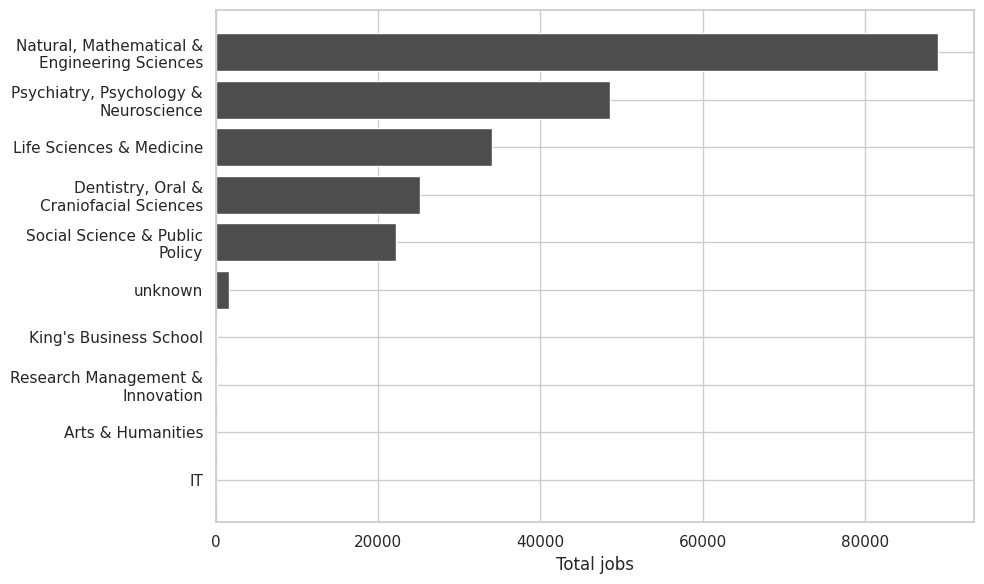

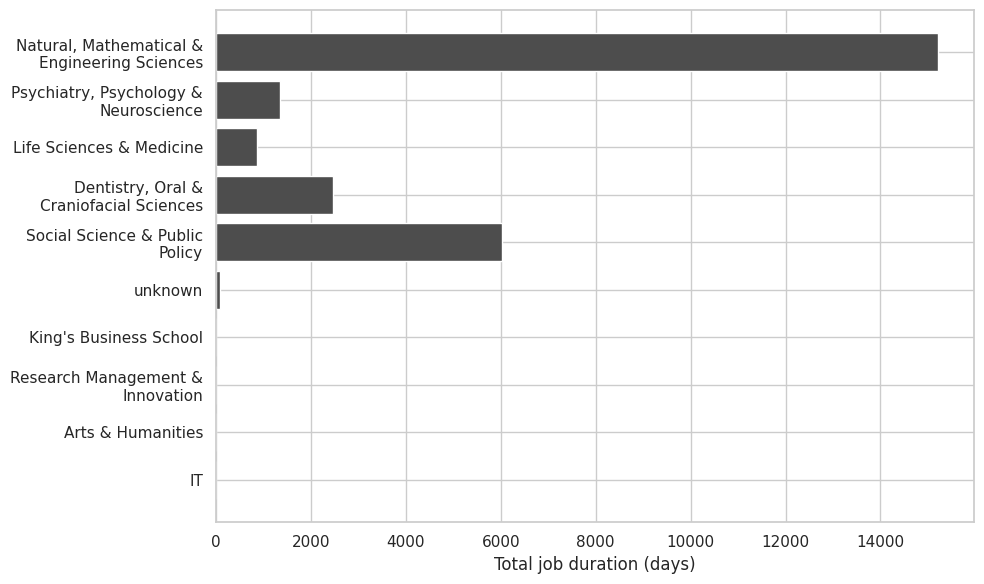

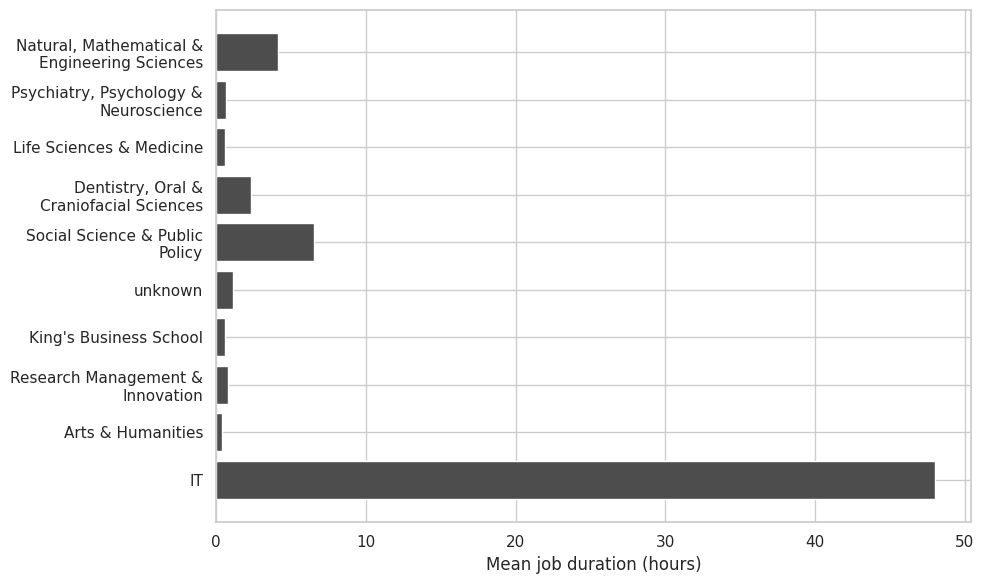

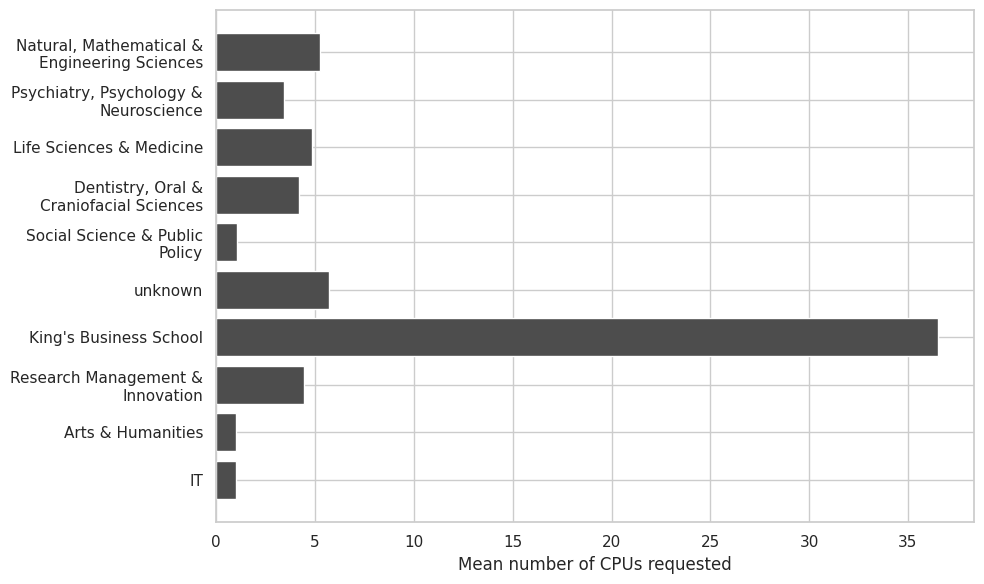

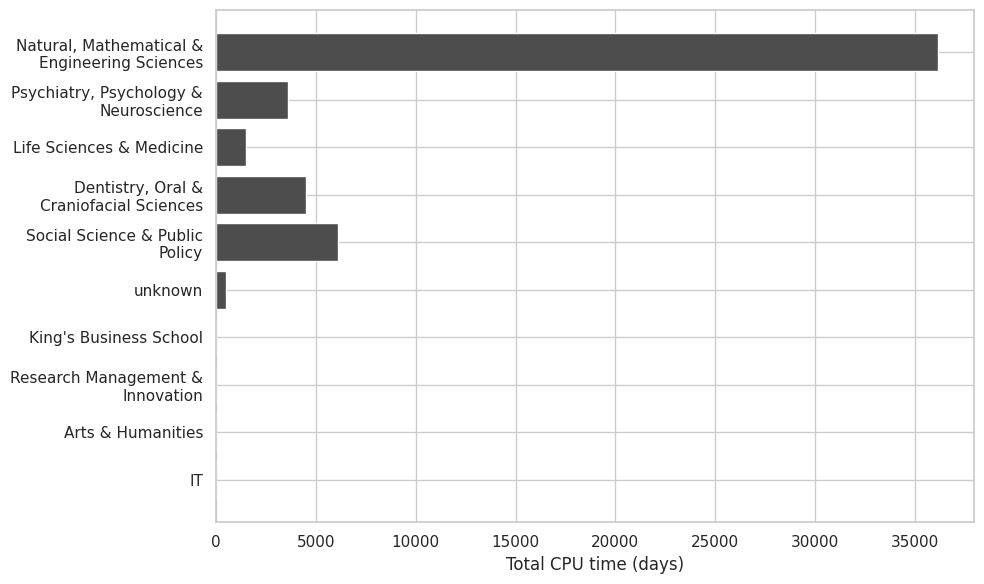

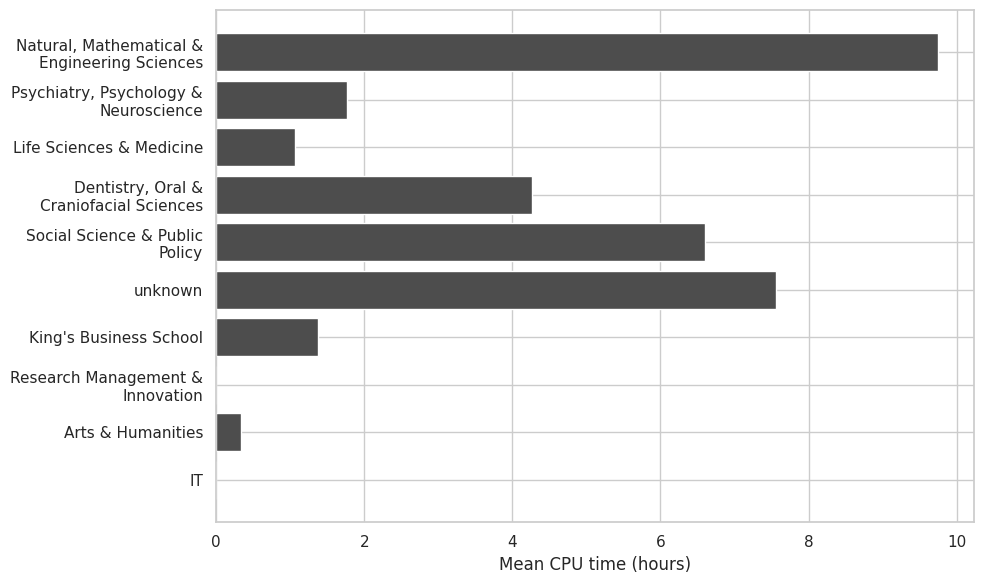

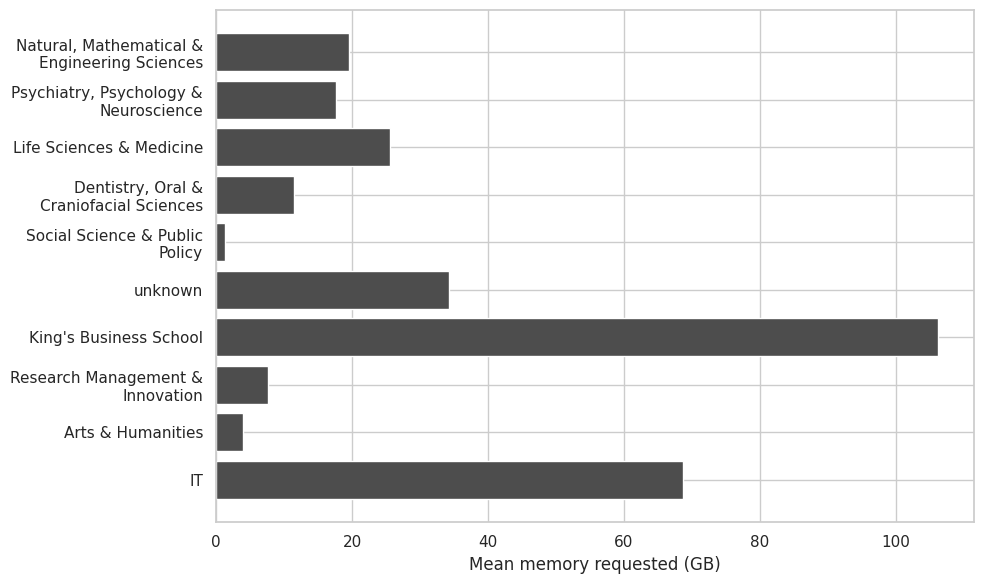

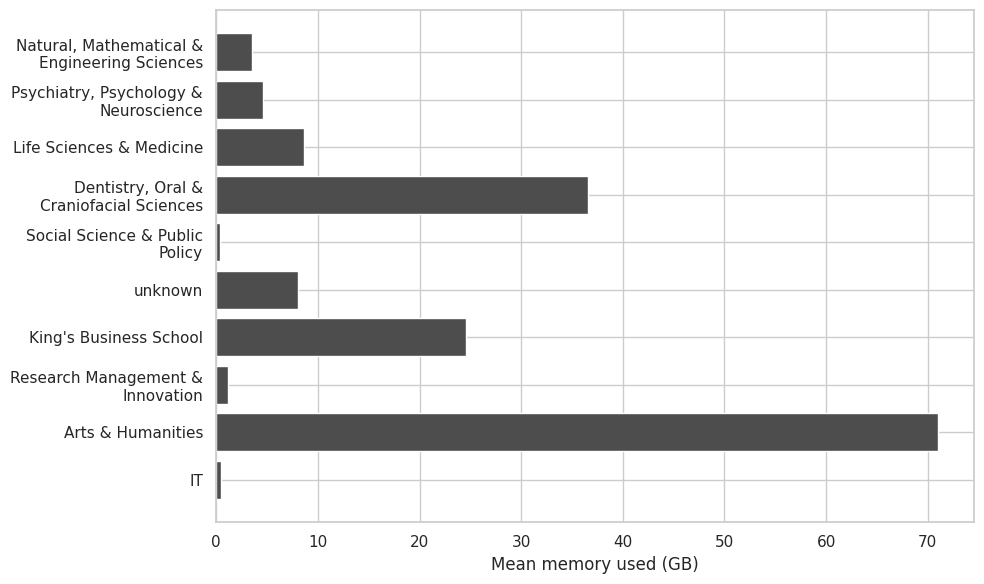

In [23]:
BAR_COLOR = '#4d4d4d'

def overview_bar(values, labels, xlabel):
    """Simple horizontal bar chart for overview metrics."""
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(labels, values, color=BAR_COLOR)
    ax.set_xlabel(xlabel)
    plt.tight_layout()
    plt.show()

# Total job count
overview_bar(df_plot['job_count'], df_plot['faculty_short'], 'Total jobs')

# Total job duration
overview_bar(df_plot['total_elapsed_sec'] / 86400, df_plot['faculty_short'],
             'Total job duration (days)')

# Mean job duration
overview_bar(df_plot['avg_elapsed_sec'] / 3600, df_plot['faculty_short'],
             'Mean job duration (hours)')

# Mean number of CPUs requested
overview_bar(df_plot['avg_alloccpus'], df_plot['faculty_short'],
             'Mean number of CPUs requested')

# Total CPU time
overview_bar(df_plot['total_cpu_sec'] / 86400, df_plot['faculty_short'],
             'Total CPU time (days)')

# Mean CPU time
overview_bar(df_plot['avg_cpu_sec'] / 3600, df_plot['faculty_short'],
             'Mean CPU time (hours)')

# Mean memory requested
overview_bar(df_plot['avg_reqmem_bytes'] / 1e9, df_plot['faculty_short'],
             'Mean memory requested (GB)')

# Mean memory used
overview_bar(df_plot['avg_maxrss_bytes'] / 1e9, df_plot['faculty_short'],
             'Mean memory used (GB)')

---
# 2. Global Stats

Key metrics for quick decision-making.

In [24]:
def create_summary():
    """Display summary statistics."""
    total_jobs = df_faculties['job_count'].sum()
    total_success = df_faculties['job_count_success'].sum()
    total_failed = df_faculties['job_count_failed'].sum()
    success_rate = (total_success / total_jobs * 100) if total_jobs > 0 else 0
    
    if len(df_global) > 0:
        global_cpu_eff = df_global['weighted_cpu_eff_pct'].values[0]
        global_mem_eff = df_global['weighted_mem_eff_pct'].values[0]
    else:
        global_cpu_eff = df_faculties['weighted_cpu_eff_pct'].mean()
        global_mem_eff = df_faculties['weighted_mem_eff_pct'].mean()
    
    avg_wait = df_faculties['avg_wait_sec'].mean() / 60
    
    summary = f"""
| Metric | Value |
|--------|-------|
| **Total Jobs** | {total_jobs:,} |
| **Success Rate** | {success_rate:.1f}% |
| **CPU Efficiency** (weighted) | {global_cpu_eff:.1f}% |
| **Memory Efficiency** (weighted) | {global_mem_eff:.1f}% |
| **Avg Queue Wait** | {avg_wait:.1f} min |
"""
    display(Markdown(summary))

create_summary()


| Metric | Value |
|--------|-------|
| **Total Jobs** | 220,741 |
| **Success Rate** | 83.9% |
| **CPU Efficiency** (weighted) | 42.0% |
| **Memory Efficiency** (weighted) | 227.5% |
| **Avg Queue Wait** | 316.2 min |


In [25]:
def efficiency_ranking():
    """Display faculty efficiency ranking (sorted by weighted CPU efficiency)."""
    ranking = df_faculties[['faculty', 'job_count', 'weighted_cpu_eff_pct', 
                            'weighted_mem_eff_pct', 'job_count_failed']].copy()
    ranking['failure_rate'] = (ranking['job_count_failed'] / ranking['job_count'] * 100).round(1)
    ranking = ranking.sort_values('weighted_cpu_eff_pct', ascending=False)
    
    display(Markdown("### Faculty Ranking by Weighted CPU Efficiency"))
    display(ranking[['faculty', 'job_count', 'weighted_cpu_eff_pct', 
                     'weighted_mem_eff_pct', 'failure_rate']].rename(columns={
        'faculty': 'Faculty', 'job_count': 'Jobs', 'weighted_cpu_eff_pct': 'CPU Eff %',
        'weighted_mem_eff_pct': 'Mem Eff %', 'failure_rate': 'Failure %'
    }))

efficiency_ranking()

### Faculty Ranking by Weighted CPU Efficiency

,Faculty,Jobs,CPU Eff %,Mem Eff %,Failure %
4,Faculty of Social Science & Public Policy,22147,96.575989,30.125526,6.3
0,Faculty of Arts & Humanities,28,84.250000,1787.343800,42.9
9,unknown,1575,71.000000,23.504361,14.4
3,"Faculty of Natural, Mathematical & Engineering...",89044,53.120000,17.871734,15.5
6,"Institute of Psychiatry, Psychology & Neurosci...",48634,45.326621,25.961013,18.2
1,"Faculty of Dentistry, Oral & Craniofacial Scie...",25190,36.282352,317.588171,13.7
2,Faculty of Life Sciences & Medicine,34005,19.969828,33.888027,22.8
7,King's Business School,72,13.610000,23.117177,11.1
8,Research Management & Innovation,44,0.030000,14.807177,70.5
5,IT,2,0.010000,0.745112,100.0


---
# 3. Detailed Analysis

Comprehensive visualisations for in-depth analysis.

## 3.1 Job Counts by Faculty

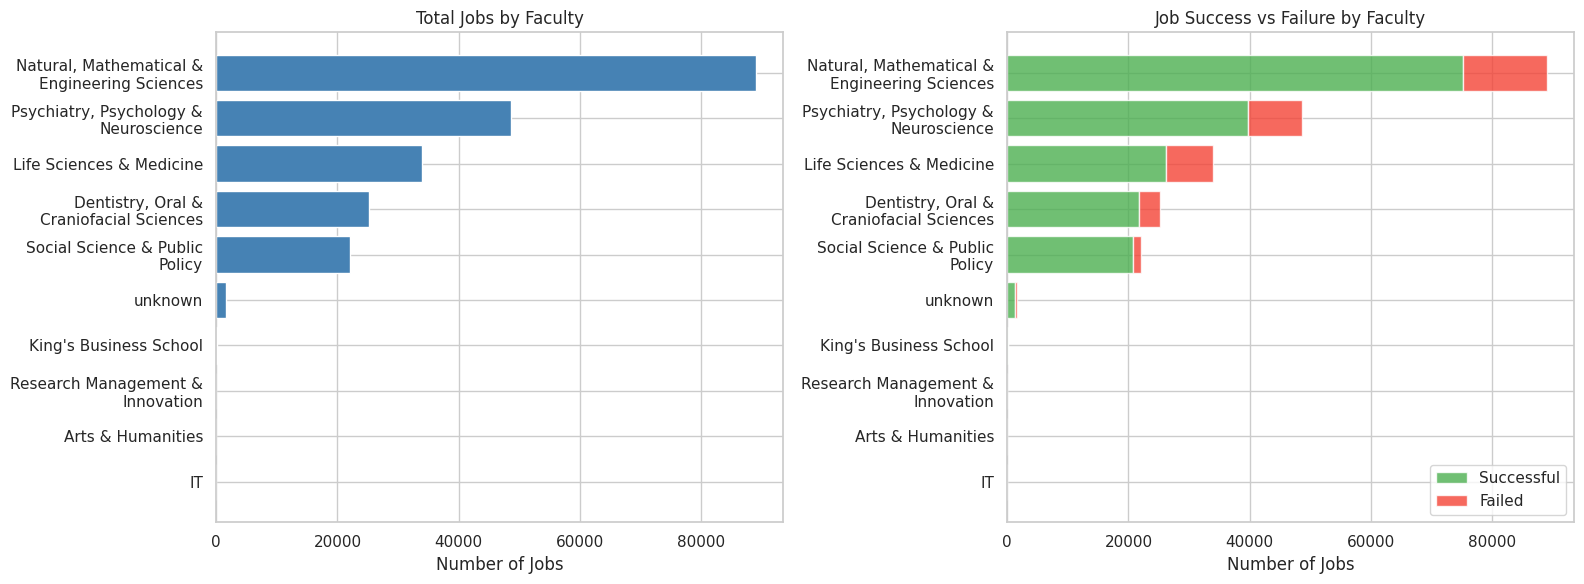

In [26]:
def plot_job_counts():
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sorted_df = df_faculties.sort_values('job_count', ascending=True)
    
    axes[0].barh(sorted_df['faculty_short'], sorted_df['job_count'], color='steelblue')
    axes[0].set_xlabel('Number of Jobs')
    axes[0].set_title('Total Jobs by Faculty')
    
    axes[1].barh(sorted_df['faculty_short'], sorted_df['job_count_success'], 
                 label='Successful', color='#4caf50', alpha=0.8)
    axes[1].barh(sorted_df['faculty_short'], sorted_df['job_count_failed'], 
                 left=sorted_df['job_count_success'], label='Failed', color='#f44336', alpha=0.8)
    axes[1].set_xlabel('Number of Jobs')
    axes[1].set_title('Job Success vs Failure by Faculty')
    axes[1].legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()

plot_job_counts()

## 3.2 Efficiency Comparisons

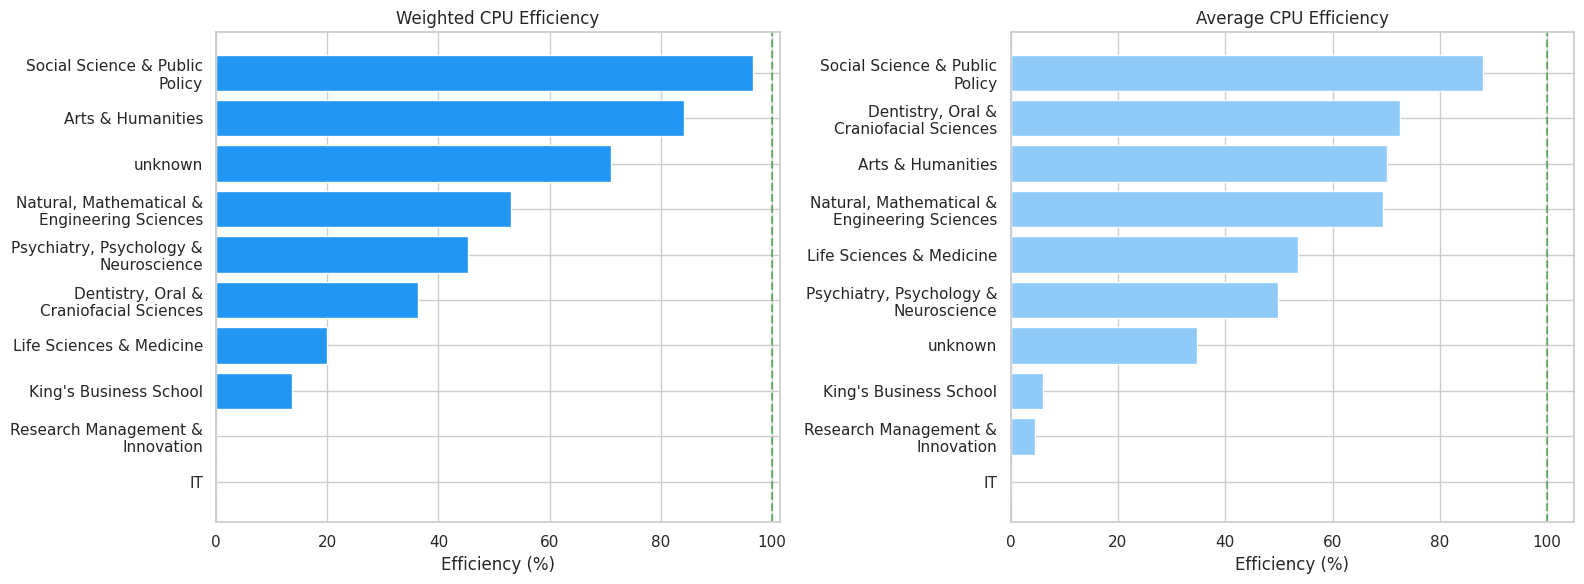

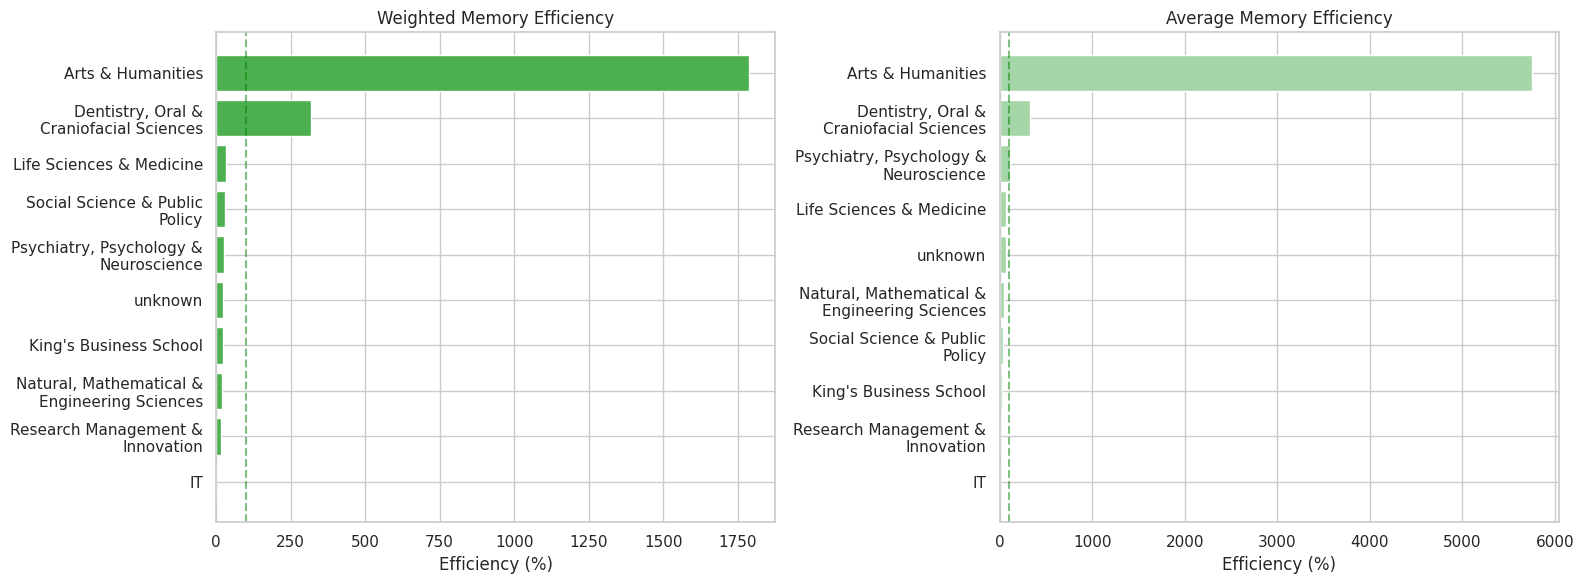

In [27]:
def plot_efficiency_comparison():
    # CPU efficiency: weighted vs average (side by side, ranked)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    sorted_df = df_faculties.sort_values('weighted_cpu_eff_pct', ascending=True)
    axes[0].barh(sorted_df['faculty_short'], sorted_df['weighted_cpu_eff_pct'], color='#2196f3')
    axes[0].set_xlabel('Efficiency (%)')
    axes[0].set_title('Weighted CPU Efficiency')
    axes[0].axvline(x=100, color='green', linestyle='--', alpha=0.5)
    
    sorted_df = df_faculties.sort_values('avg_cpu_eff_pct', ascending=True)
    axes[1].barh(sorted_df['faculty_short'], sorted_df['avg_cpu_eff_pct'], color='#90caf9')
    axes[1].set_xlabel('Efficiency (%)')
    axes[1].set_title('Average CPU Efficiency')
    axes[1].axvline(x=100, color='green', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Memory efficiency: weighted vs average (side by side, ranked)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    sorted_df = df_faculties.sort_values('weighted_mem_eff_pct', ascending=True)
    axes[0].barh(sorted_df['faculty_short'], sorted_df['weighted_mem_eff_pct'], color='#4caf50')
    axes[0].set_xlabel('Efficiency (%)')
    axes[0].set_title('Weighted Memory Efficiency')
    axes[0].axvline(x=100, color='green', linestyle='--', alpha=0.5)
    
    sorted_df = df_faculties.sort_values('avg_mem_eff_pct', ascending=True)
    axes[1].barh(sorted_df['faculty_short'], sorted_df['avg_mem_eff_pct'], color='#a5d6a7')
    axes[1].set_xlabel('Efficiency (%)')
    axes[1].set_title('Average Memory Efficiency')
    axes[1].axvline(x=100, color='green', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

plot_efficiency_comparison()

In [ ]:
def plot_waste_and_utilisation():
    """Cluster-wide utilisation pies and per-faculty waste bar charts."""

    # --- Cluster-wide pie charts ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Memory utilisation
    total_mem_requested = df_faculties['total_reqmem_bytes'].sum() / 1e12
    total_mem_used = df_faculties['total_maxrss_bytes'].sum() / 1e12
    total_mem_wasted = max(0, total_mem_requested - total_mem_used)

    axes[0].pie([total_mem_used, total_mem_wasted],
                labels=[f'Used\n{total_mem_used:.1f} TB', f'Wasted\n{total_mem_wasted:.1f} TB'],
                colors=['#4caf50', '#f44336'], autopct='%1.1f%%',
                startangle=90, explode=(0, 0.1))
    axes[0].set_title('Cluster-Wide Memory Utilisation')

    # CPU utilisation
    cpu_allocated = np.where(
        df_faculties['weighted_cpu_eff_pct'] > 0,
        df_faculties['total_cpu_sec'] * 100 / df_faculties['weighted_cpu_eff_pct'],
        0)
    total_cpu_used = df_faculties['total_cpu_sec'].sum() / 86400
    total_cpu_allocated = cpu_allocated.sum() / 86400
    total_cpu_wasted = max(0, total_cpu_allocated - total_cpu_used)

    axes[1].pie([total_cpu_used, total_cpu_wasted],
                labels=[f'Used\n{total_cpu_used:,.0f} days', f'Wasted\n{total_cpu_wasted:,.0f} days'],
                colors=['#4caf50', '#f44336'], autopct='%1.1f%%',
                startangle=90, explode=(0, 0.1))
    axes[1].set_title('Cluster-Wide CPU Utilisation')

    plt.tight_layout()
    plt.show()

    # --- Per-faculty waste bar charts ---
    df_faculties['mem_wasted_tb'] = ((df_faculties['total_reqmem_bytes'] -
                                       df_faculties['total_maxrss_bytes']) / 1e12).clip(lower=0)
    df_faculties['cpu_wasted_days'] = ((cpu_allocated - df_faculties['total_cpu_sec']) / 86400).clip(lower=0)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    sorted_df = df_faculties.sort_values('mem_wasted_tb', ascending=True)
    axes[0].barh(sorted_df['faculty_short'], sorted_df['mem_wasted_tb'], color='#f44336', alpha=0.7)
    axes[0].set_xlabel('Wasted Memory (TB)')
    axes[0].set_title('Memory Waste by Faculty (Requested - Used)')

    sorted_df = df_faculties.sort_values('cpu_wasted_days', ascending=True)
    axes[1].barh(sorted_df['faculty_short'], sorted_df['cpu_wasted_days'], color='#f44336', alpha=0.7)
    axes[1].set_xlabel('Wasted CPU Time (days)')
    axes[1].set_title('CPU Waste by Faculty (Allocated - Used)')

    plt.tight_layout()
    plt.show()

plot_waste_and_utilisation()

## 3.3 Wait Time Analysis

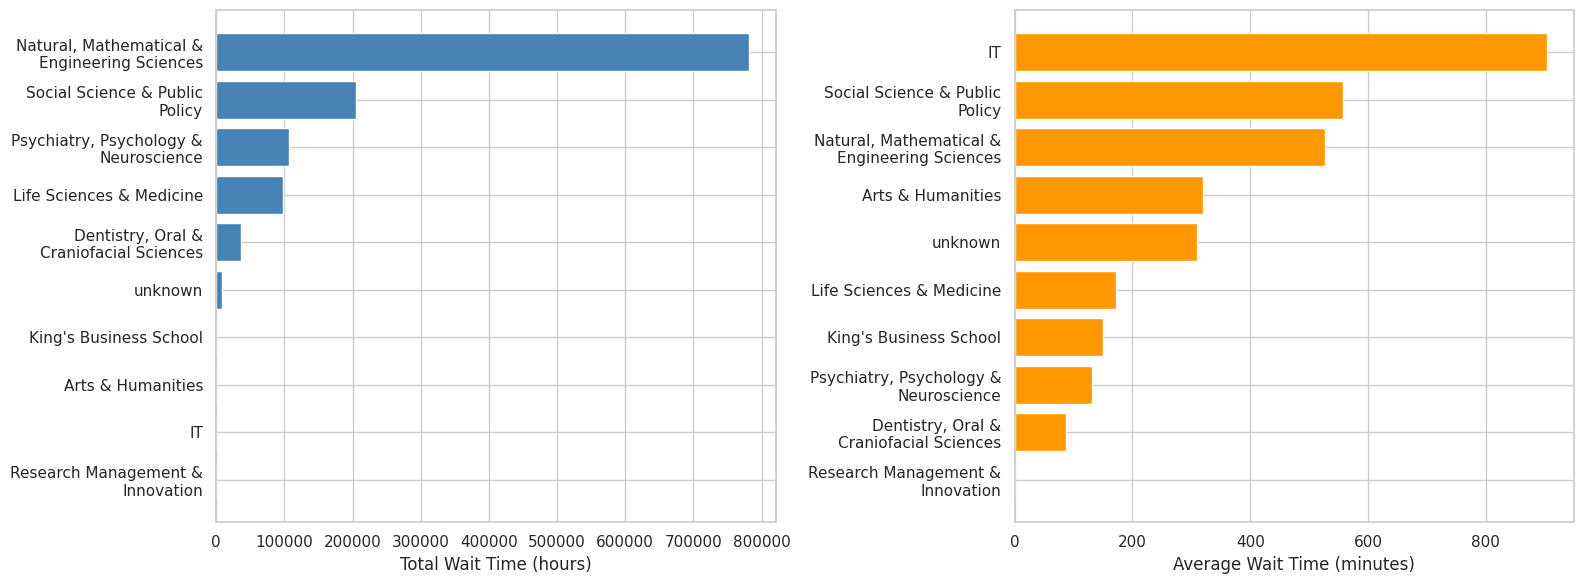

In [28]:
def plot_wait_time():
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    sorted_df = df_faculties.sort_values('total_wait_sec', ascending=True)
    axes[0].barh(sorted_df['faculty_short'], sorted_df['total_wait_sec'] / 3600,
                 color='steelblue')
    axes[0].set_xlabel('Total Wait Time (hours)')
    
    sorted_df = df_faculties.sort_values('avg_wait_sec', ascending=True)
    axes[1].barh(sorted_df['faculty_short'], sorted_df['avg_wait_sec'] / 60,
                 color='#ff9800')
    axes[1].set_xlabel('Average Wait Time (minutes)')
    
    plt.tight_layout()
    plt.show()

plot_wait_time()

## 3.4 Job-level Analysis

Per-job efficiency distributions using violin plots. This shows variance and outliers within each faculty. All violins are scaled to the same maximum width (`density_norm='width'`), so their shapes show the *relative* distribution within each faculty but their widths are not comparable across faculties.

**Note:** This section requires the per-job data file generated by:
```bash
hpc-job-stats --include-faculty --since 2025-01-01 --until 2025-02-01 --output ../results/job_level_metrics.csv
```

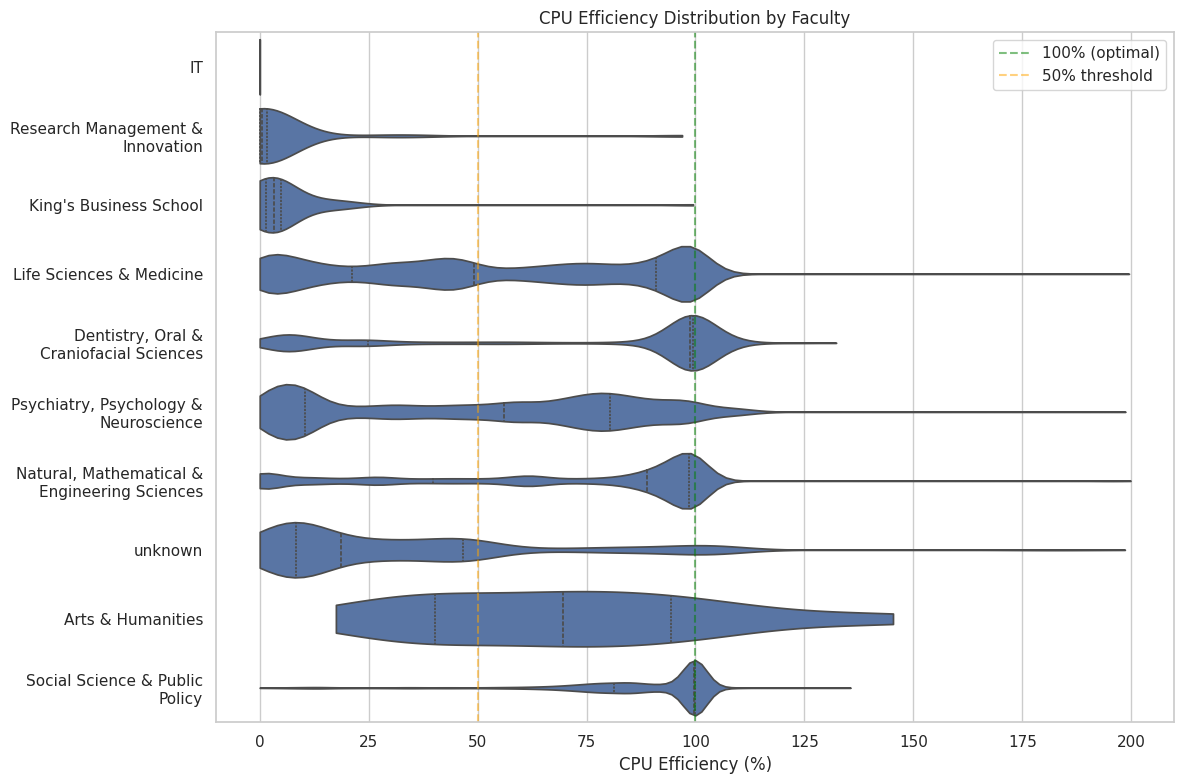

In [29]:
def plot_violin_cpu_efficiency():
    """Violin plot of CPU efficiency distribution by faculty."""
    if not HAS_JOB_DATA:
        print("Per-job data not available. Run job_level_metrics.py first.")
        return
    
    if 'faculty' not in df_jobs.columns:
        print("Faculty column not in job data. Run job_level_metrics.py with --include-faculty.")
        return
    
    plot_data = df_jobs[df_jobs['cpu_eff_pct'].notna() & (df_jobs['cpu_eff_pct'] <= 200)].copy()
    top_faculties = plot_data['faculty'].value_counts().head(10).index.tolist()
    plot_data = plot_data[plot_data['faculty'].isin(top_faculties)]
    
    # Use same ranking as weighted efficiency bar plots
    ranking = (df_faculties[df_faculties['faculty'].isin(top_faculties)]
               .sort_values('weighted_cpu_eff_pct'))
    order = [FACULTY_SHORT.get(f, f) for f in ranking['faculty']]
    
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.violinplot(data=plot_data, y='faculty_short', x='cpu_eff_pct', ax=ax,
                   cut=0, order=order, density_norm='width', inner='quartile')
    ax.axvline(x=100, color='green', linestyle='--', alpha=0.5, label='100% (optimal)')
    ax.axvline(x=50, color='orange', linestyle='--', alpha=0.5, label='50% threshold')
    ax.set_ylabel('')
    ax.set_xlabel('CPU Efficiency (%)')
    ax.set_title('CPU Efficiency Distribution by Faculty')
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_violin_cpu_efficiency()

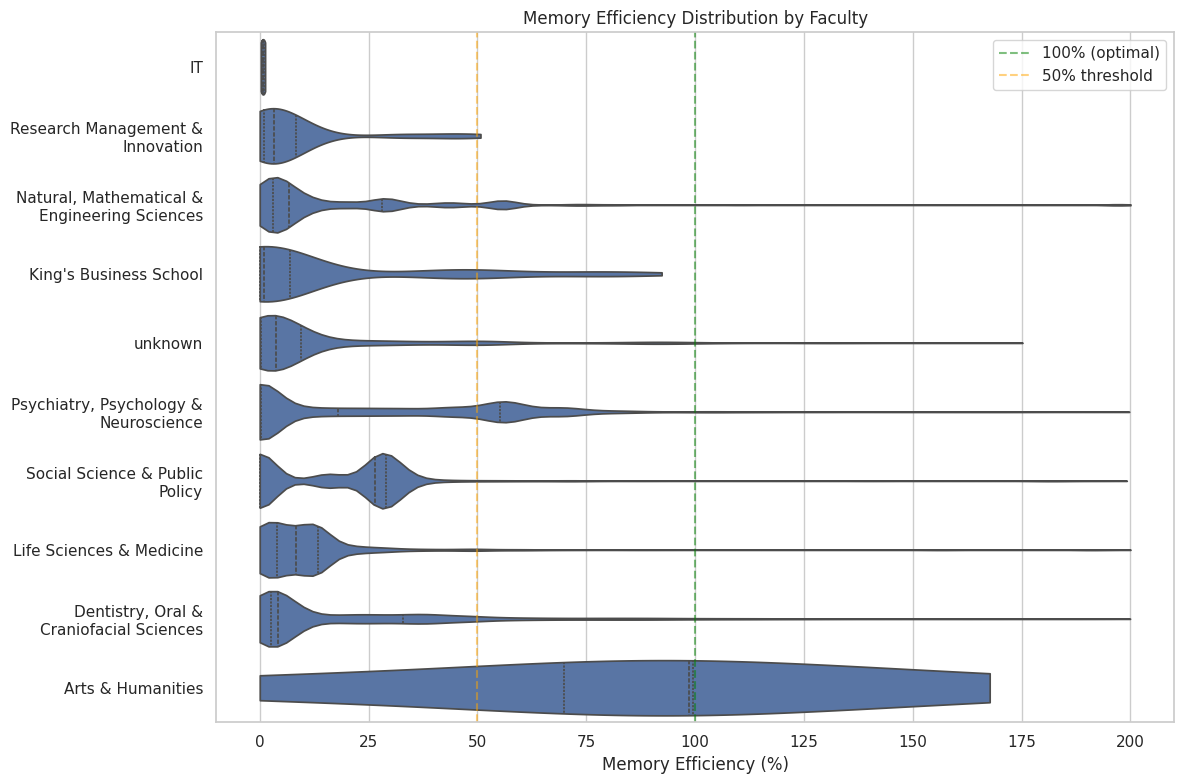

In [30]:
def plot_violin_memory_efficiency():
    """Violin plot of memory efficiency distribution by faculty."""
    if not HAS_JOB_DATA:
        print("Per-job data not available. Run job_level_metrics.py first.")
        return
    
    if 'faculty' not in df_jobs.columns:
        print("Faculty column not in job data. Run job_level_metrics.py with --include-faculty.")
        return
    
    plot_data = df_jobs[df_jobs['mem_eff_pct'].notna() & (df_jobs['mem_eff_pct'] <= 200)].copy()
    top_faculties = plot_data['faculty'].value_counts().head(10).index.tolist()
    plot_data = plot_data[plot_data['faculty'].isin(top_faculties)]
    
    # Use same ranking as weighted efficiency bar plots
    ranking = (df_faculties[df_faculties['faculty'].isin(top_faculties)]
               .sort_values('weighted_mem_eff_pct'))
    order = [FACULTY_SHORT.get(f, f) for f in ranking['faculty']]
    
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.violinplot(data=plot_data, y='faculty_short', x='mem_eff_pct', ax=ax,
                   cut=0, order=order, density_norm='width', inner='quartile')
    ax.axvline(x=100, color='green', linestyle='--', alpha=0.5, label='100% (optimal)')
    ax.axvline(x=50, color='orange', linestyle='--', alpha=0.5, label='50% threshold')
    ax.set_ylabel('')
    ax.set_xlabel('Memory Efficiency (%)')
    ax.set_title('Memory Efficiency Distribution by Faculty')
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_violin_memory_efficiency()

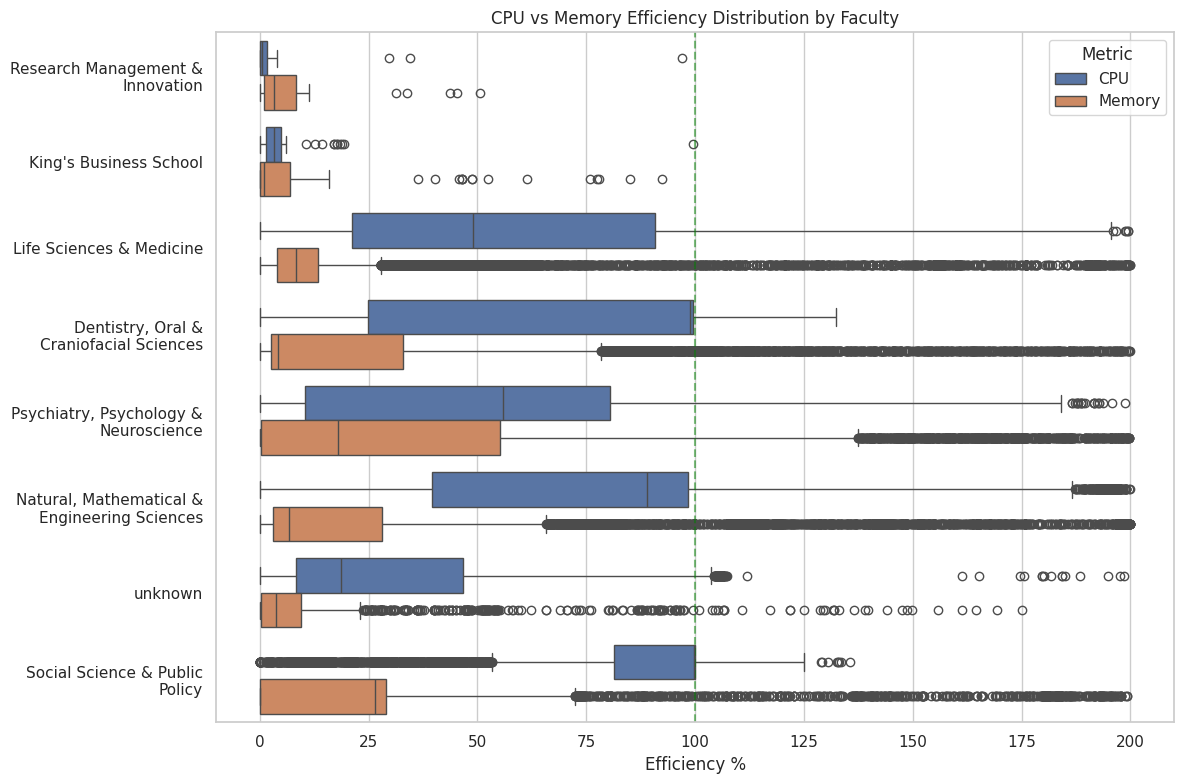

In [31]:
def plot_box_comparison():
    """Box plots comparing CPU and memory efficiency side by side."""
    if not HAS_JOB_DATA:
        print("Per-job data not available.")
        return
    
    if 'faculty' not in df_jobs.columns:
        print("Faculty column not in job data.")
        return
    
    top_faculties = df_jobs['faculty'].value_counts().head(8).index.tolist()
    plot_data = df_jobs[df_jobs['faculty'].isin(top_faculties)].copy()
    
    # Use same ranking as weighted efficiency bar plots (by weighted CPU efficiency)
    ranking = (df_faculties[df_faculties['faculty'].isin(top_faculties)]
               .sort_values('weighted_cpu_eff_pct'))
    order = [FACULTY_SHORT.get(f, f) for f in ranking['faculty']]
    
    melt_data = plot_data[['faculty_short', 'cpu_eff_pct', 'mem_eff_pct']].melt(
        id_vars='faculty_short', value_vars=['cpu_eff_pct', 'mem_eff_pct'],
        var_name='Metric', value_name='Efficiency %'
    )
    melt_data = melt_data[melt_data['Efficiency %'].notna() & (melt_data['Efficiency %'] <= 200)]
    melt_data['Metric'] = melt_data['Metric'].map({'cpu_eff_pct': 'CPU', 'mem_eff_pct': 'Memory'})
    
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.boxplot(data=melt_data, y='faculty_short', x='Efficiency %', hue='Metric',
                ax=ax, order=order)
    ax.axvline(x=100, color='green', linestyle='--', alpha=0.5)
    ax.set_ylabel('')
    ax.set_title('CPU vs Memory Efficiency Distribution by Faculty')
    plt.tight_layout()
    plt.show()

plot_box_comparison()

---
# 4. Correlation Analysis

Investigating relationships between per-job metrics. We use per-job data (from `job_level_metrics.csv`) rather than faculty-level aggregates to ensure sufficient sample size for meaningful statistics. We first check normality to determine the appropriate correlation method.

In [32]:
def test_normality(data, name):
    """Test for normality using Shapiro-Wilk test."""
    clean_data = data.dropna()
    if len(clean_data) < 3:
        return None, None
    # Shapiro-Wilk has a limit of 5000 samples; use a random subsample if larger
    if len(clean_data) > 5000:
        clean_data = clean_data.sample(5000, random_state=42)
    stat, p_value = stats.shapiro(clean_data)
    return stat, p_value

def normality_report():
    """Report on normality of key per-job metrics."""
    if not HAS_JOB_DATA:
        print("Per-job data not available. Run job_level_metrics.py first.")
        return

    metrics = ['cpu_eff_pct', 'mem_eff_pct', 'time_eff_pct', 'wait_sec', 'elapsed_sec']
    metrics = [m for m in metrics if m in df_jobs.columns]

    results = []
    for metric in metrics:
        stat, p = test_normality(df_jobs[metric], metric)
        if p is not None:
            normal = "Yes" if p > 0.05 else "No"
            results.append(f"| {metric} | {stat:.3f} | {p:.4f} | {normal} |")

    n = len(df_jobs)
    report = f"""### Normality Tests (Shapiro-Wilk) on Per-Job Data

Sample size: **{n:,}** jobs (subsampled to 5,000 if larger for Shapiro-Wilk)

| Metric | Statistic | p-value | Normal? (p>0.05) |
|--------|-----------|---------|------------------|
""" + "\n".join(results) + """

**Interpretation:** If data is not normally distributed, we use Spearman correlation (rank-based) instead of Pearson.
"""
    display(Markdown(report))

normality_report()

### Normality Tests (Shapiro-Wilk) on Per-Job Data

Sample size: **220,741** jobs (subsampled to 5,000 if larger for Shapiro-Wilk)

| Metric | Statistic | p-value | Normal? (p>0.05) |
|--------|-----------|---------|------------------|
| cpu_eff_pct | 0.853 | 0.0000 | No |
| mem_eff_pct | 0.161 | 0.0000 | No |
| time_eff_pct | 0.667 | 0.0000 | No |
| wait_sec | 0.493 | 0.0000 | No |
| elapsed_sec | 0.158 | 0.0000 | No |

**Interpretation:** If data is not normally distributed, we use Spearman correlation (rank-based) instead of Pearson.


Correlation computed on **219,530** jobs with complete data.

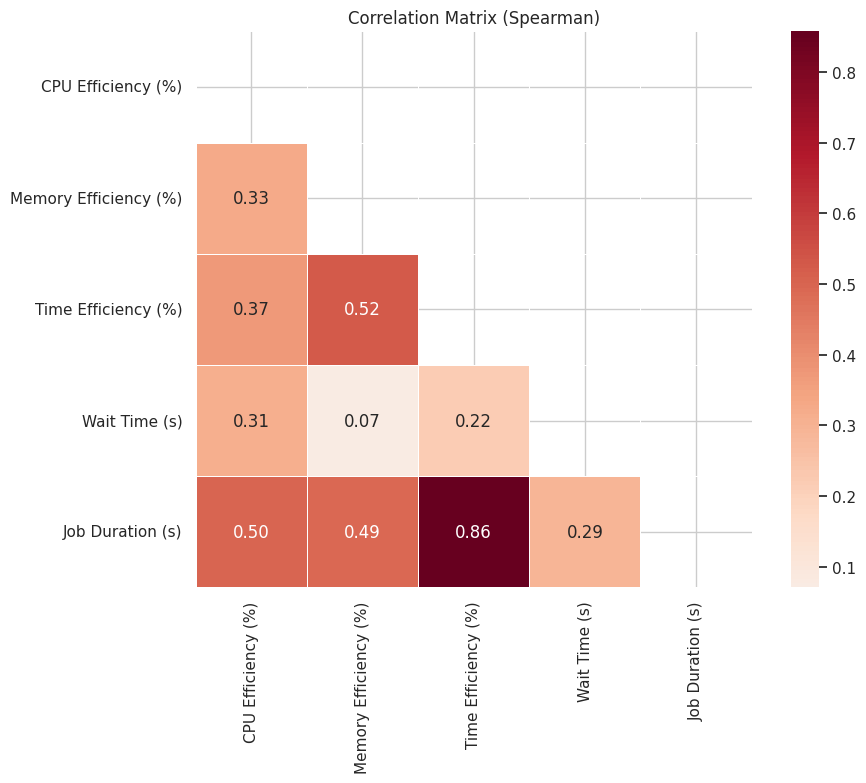

**CPU vs Memory Efficiency:** r = 0.328, p = 0.00e+00 (n = 219,530)

In [33]:
def correlation_analysis():
    """Compute and visualise correlation matrix using per-job data."""
    if not HAS_JOB_DATA:
        print("Per-job data not available. Run job_level_metrics.py first.")
        return

    nice_names = {
        'cpu_eff_pct': 'CPU Efficiency (%)',
        'mem_eff_pct': 'Memory Efficiency (%)',
        'time_eff_pct': 'Time Efficiency (%)',
        'wait_sec': 'Wait Time (s)',
        'elapsed_sec': 'Job Duration (s)',
    }

    corr_cols = [c for c in nice_names if c in df_jobs.columns]
    corr_data = df_jobs[corr_cols].dropna()
    corr_data = corr_data.rename(columns=nice_names)

    display(Markdown(f"Correlation computed on **{len(corr_data):,}** jobs with complete data."))

    # Use Spearman (more robust for non-normal data)
    corr_matrix = corr_data.corr(method='spearman')

    fig, ax = plt.subplots(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
                center=0, square=True, linewidths=0.5, ax=ax)
    ax.set_title('Correlation Matrix (Spearman)', fontsize=12)
    plt.tight_layout()
    plt.show()

    cpu_name = nice_names.get('cpu_eff_pct')
    mem_name = nice_names.get('mem_eff_pct')
    if cpu_name in corr_matrix.columns and mem_name in corr_matrix.columns:
        valid = corr_data[[cpu_name, mem_name]].dropna()
        rho, pval = stats.spearmanr(valid[cpu_name], valid[mem_name])
        display(Markdown(
            f"**CPU vs Memory Efficiency:** r = {rho:.3f}, p = {pval:.2e} "
            f"(n = {len(valid):,})"
        ))

correlation_analysis()

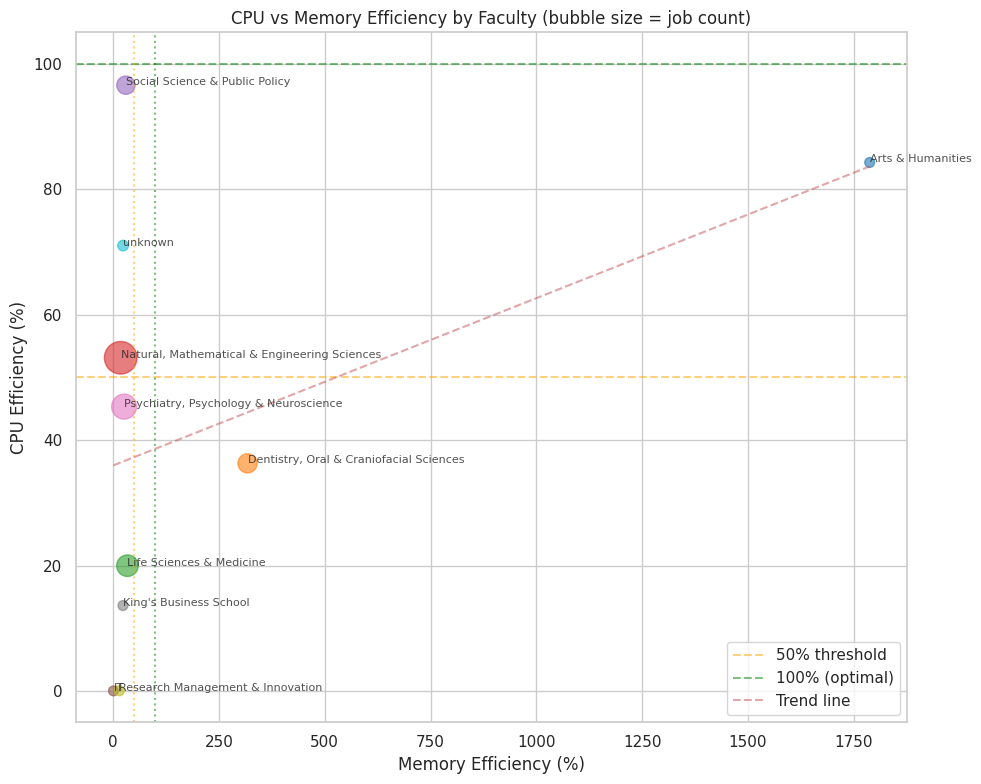

In [34]:
def cpu_memory_scatter():
    """Scatter plot: Does poor CPU efficiency coincide with poor memory efficiency?"""
    fig, ax = plt.subplots(figsize=(10, 8))
    
    plot_df = df_faculties.dropna(subset=['weighted_cpu_eff_pct', 'weighted_mem_eff_pct'])
    
    ax.scatter(plot_df['weighted_mem_eff_pct'], plot_df['weighted_cpu_eff_pct'],
               s=plot_df['job_count']/plot_df['job_count'].max()*500+50,
               alpha=0.6, c=range(len(plot_df)), cmap='tab10')
    
    for idx, row in plot_df.iterrows():
        ax.annotate(row['faculty_short'].replace('\n', ' '),
                    (row['weighted_mem_eff_pct'], row['weighted_cpu_eff_pct']),
                   fontsize=8, alpha=0.8)
    
    ax.axhline(y=50, color='orange', linestyle='--', alpha=0.5, label='50% threshold')
    ax.axhline(y=100, color='green', linestyle='--', alpha=0.5, label='100% (optimal)')
    ax.axvline(x=50, color='orange', linestyle=':', alpha=0.5)
    ax.axvline(x=100, color='green', linestyle=':', alpha=0.5)
    
    # Add regression line
    z = np.polyfit(plot_df['weighted_mem_eff_pct'], plot_df['weighted_cpu_eff_pct'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(plot_df['weighted_mem_eff_pct'].min(), plot_df['weighted_mem_eff_pct'].max(), 100)
    ax.plot(x_line, p(x_line), 'r--', alpha=0.5, label='Trend line')
    
    ax.set_xlabel('Memory Efficiency (%)')
    ax.set_ylabel('CPU Efficiency (%)')
    ax.set_title('CPU vs Memory Efficiency by Faculty (bubble size = job count)')
    ax.legend()
    plt.tight_layout()
    plt.show()

cpu_memory_scatter()

---
# 5. Why Efficiency Matters

## The Problem: Resource Waste

When you request resources (CPUs, memory) for your job, those resources are **reserved exclusively for you**, even if you don't use them. This means:

- Other users can't run their jobs while your resources sit idle
- Queue wait times increase for everyone
- The cluster appears "full" when it's actually underutilised

## Example: Memory Over-requesting

If you request **64 GB** of memory but only use **2 GB**:
- Efficiency: 2/64 = **3.1%**
- Wasted: 62 GB that could have run **31 other 2GB jobs**

## What "Good" Efficiency Looks Like

| Range | Rating | Meaning |
|-------|--------|---------|
| 70–100% | Excellent | You're using what you requested |
| 30–70% | Acceptable | Room for improvement |
| <30% | Poor | Significant waste — please optimise |
| >100% | See note | Not necessarily a problem (see below) |

**Efficiency >100%** has different causes for CPU and memory:
- **CPU >100%**: The job used more CPU time than `elapsed × requested CPUs`. This typically happens when code spawns threads internally (e.g., OpenMP) without Slurm being aware — Slurm cannot track the actual thread count. It does not mean the user did anything wrong.
- **Memory >100%**: The job used more memory than it requested. This can happen if memory limits are not enforced by the cluster (see Technical Appendix). The job was not killed because Slurm's memory enforcement is a configuration option, not a default.

## How to Improve Your Efficiency

1. **Profile your jobs first** — Run a small test job and check actual resource usage with `seff <jobid>`
2. **Request what you need (plus 10–20% buffer)** — If your test used 8 GB, request 10 GB, not 64 GB "just in case"
3. **Use job arrays for many small jobs** — Instead of requesting 100 CPUs for one job, submit 100 single-CPU jobs
4. **Check your code's parallelisation** — If you request 16 CPUs but your code only uses 1, you're wasting 15 CPUs
5. **Attend HPC training** — Learn best practices for efficient cluster usage

---
# 6. Technical Appendix

## Data Sources

- **Job data:** Slurm accounting database (MySQL), accessed directly via `mysql.connector` (not via `sacct`, for reliability).
  - `create_job_table`: job metadata — timestamps, resource requests (`cpus_req`, `tres_req`), state, exit code, time limit
  - `create_step_table`: per-step CPU time (`user_sec`, `sys_sec`) and peak memory usage (`tres_usage_in_max`)
  - `create_assoc_table`: maps job associations to usernames
- **Faculty mapping:** Active Directory via LDAP. Each username is looked up to retrieve its faculty attribute (`st`).

## Efficiency Metrics

### Weighted vs Average

We compute two versions of each efficiency metric:

| Version | Formula | Question it answers |
|---------|---------|---------------------|
| **Weighted** | Sum(used) / Sum(allocated) × 100 | "How efficiently are allocated resources being used overall?" Larger jobs contribute more. |
| **Average** | Mean(per-job efficiency) | "What's the typical job's efficiency?" Each job counts equally. |

**Example** — CPU efficiency for a faculty with 2 jobs:

| Job | TotalCPU | Elapsed | CPUs | Job Efficiency |
|-----|----------|---------|------|----------------|
| A   | 90s      | 100s    | 1    | 90%            |
| B   | 1800s    | 10000s  | 2    | 9%             |

- **Weighted:** (90 + 1800) / (100×1 + 10000×2) = 1890 / 20100 = **9.4%** — dominated by Job B, which used far more resources
- **Average:** (90% + 9%) / 2 = **49.5%** — each job counts equally

### CPU Efficiency

`CPU Efficiency = TotalCPU / (Elapsed × CPUs Requested) × 100`

- **TotalCPU** = user-mode CPU seconds + system-mode CPU seconds + microsecond fractions. This is summed across all computation steps of the job (see "CPU time and step handling" below).
- **CPUs Requested** = `cpus_req` from the job table.

**Why it can exceed 100%:** Slurm tracks CPU time via kernel accounting but does not track how many hardware threads a process uses. A program can spawn threads internally (e.g., OpenMP, Python multiprocessing) without Slurm knowing. If a job requests 1 CPU but runs 4 threads, TotalCPU can be ~4× the elapsed time, giving ~400% efficiency. There is no way to detect the actual thread count from the accounting database.

### Memory Efficiency

`Memory Efficiency = MaxRSS / ReqMem × 100`

- **MaxRSS**: Peak memory usage, extracted from `tres_usage_in_max` in the step table (TRES ID 2). The numeric maximum across all steps is used.
- **ReqMem**: Requested memory, extracted from `tres_req` in the job table (TRES ID 2), in MB. This is always stored as total memory regardless of whether the user specified `--mem` (per-node) or `--mem-per-cpu` — Slurm multiplies per-cpu values by the CPU count before storing.

**Why it can exceed 100%:** Memory limits are **not enforced** on this cluster. A diagnostic found 2,082,500 jobs with memory efficiency >100%, all using per-node memory requests. Extreme cases include 100-CPU jobs requesting only 1 GB (likely a Slurm default) but using 60–70 GB (6000%+ efficiency). Memory enforcement requires the `cgroup` plugin with `ConstrainRAMSpace=yes` in `cgroup.conf`; without it, jobs can exceed their requested memory without being killed.

### Time Efficiency

`Time Efficiency = Elapsed / (Timelimit × 60) × 100`

Measures what fraction of the requested wall-clock time was actually used. Timelimit is stored in minutes in the database.

### Wait Time

`Wait Time = time_start − time_submit`

How long a job sat in the queue before starting. Shown as both total (sum across all jobs in a faculty) and average (typical queue experience).

## CPU Time and Step Handling

Slurm records CPU time per step within each job. There are two kinds of steps:

- **Batch step**: the shell process running the job script (always exists)
- **Regular steps** (0, 1, 2, ...): created by `srun` calls within the script

For jobs using `srun`, the batch step records only shell overhead (0–2 seconds of CPU), while the srun steps carry the actual computation. Summing all steps would double-count. The SQL query therefore sums only regular steps, falling back to the batch step for jobs that have no `srun` steps.

Step IDs for batch and other internal steps (like `interactive`) are discovered dynamically at startup rather than hardcoded, for portability across Slurm versions.

## MaxRSS Extraction

Memory usage is stored in TRES (Trackable RESources) strings like `"1=500,2=12345678,4=1"`, where each ID=value pair represents a resource type (1=CPU, 2=memory, 4=nodes). To get MaxRSS, the memory value (TRES ID 2) is extracted numerically in SQL using `SUBSTRING_INDEX`, cast to an unsigned integer, and then the numeric `MAX` is taken across steps. This avoids a pitfall where `MAX()` on the raw string would do lexicographic comparison.

## Job States Included

Only finished jobs are analysed: COMPLETED (3), CANCELLED (4), FAILED (5), TIMEOUT (6), NODE_FAIL (7), PREEMPTED (8). These codes are from Slurm's standard state definitions (`slurm.h`).

## Faculty Merging

Four pairs of historically different names for the same faculty are merged before analysis:

| Old name | Merged into |
|----------|-------------|
| Faculty of Life Sciences and Medicine | Faculty of Life Sciences & Medicine |
| IoPPN | Institute of Psychiatry, Psychology & Neuroscience |
| Dentistry, Oral & Craniofacial Sciences | Faculty of Dentistry, Oral & Craniofacial Sciences |
| Social Science & Public Policy | Faculty of Social Science & Public Policy |

## Open Questions

1. **CPU efficiency denominator**: Currently uses `cpus_req` (what the user requested). A diagnostic showed that 5.5% of jobs have more CPUs *allocated* than requested (most commonly 1→2, likely due to hyperthreading at the core level). Using allocated CPUs instead would lower efficiency for those jobs, but the extra allocation is outside the user's control.
2. **MaxRSS units**: The code treats `tres_usage_in_max` TRES ID 2 values as bytes. This should be verified against `sacct` output for the same jobs.

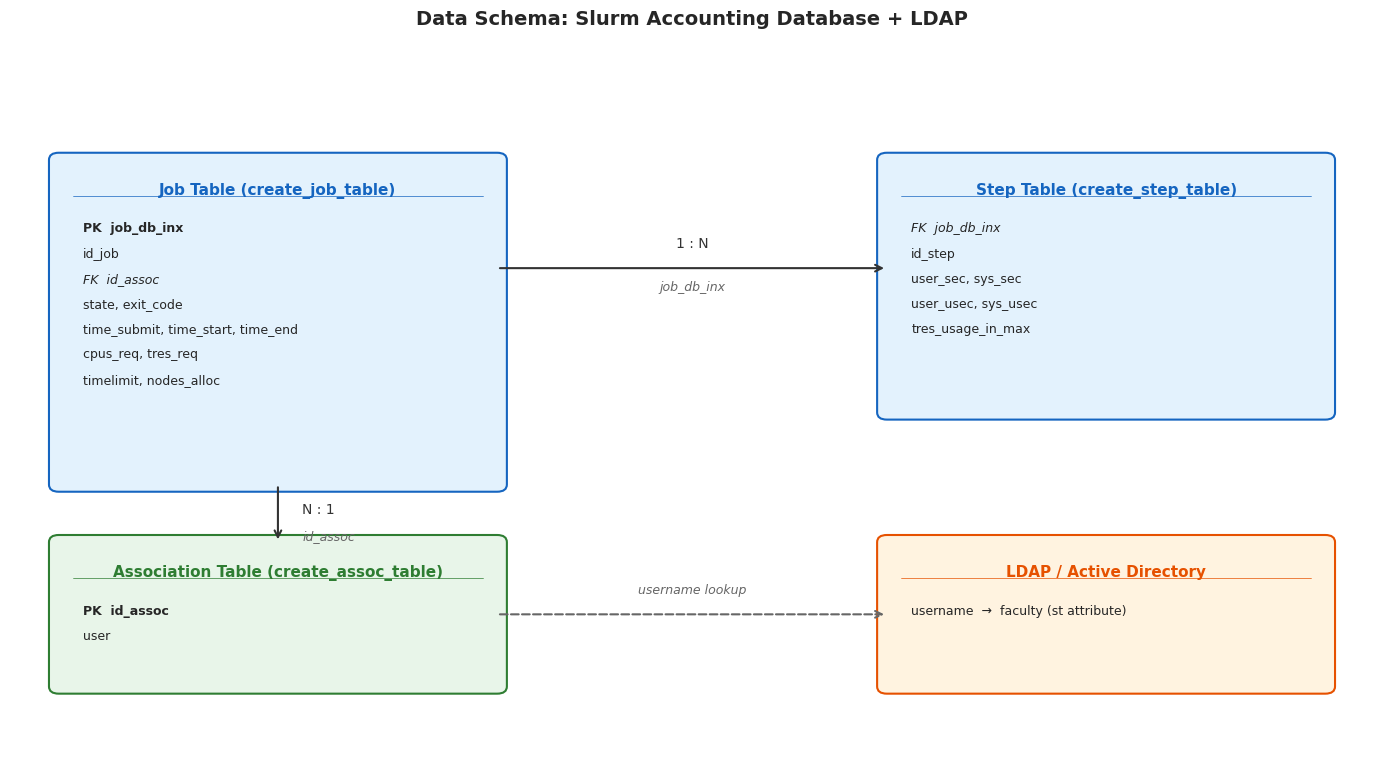

In [36]:
def draw_db_schema():
    """Draw the database schema showing how Slurm tables and LDAP relate."""
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.set_xlim(0, 14)
    ax.set_ylim(0, 10)
    ax.axis('off')
    ax.set_title('Data Schema: Slurm Accounting Database + LDAP',
                 fontsize=14, fontweight='bold', pad=20)

    def draw_table(x, y, w, h, title, columns, color='#e3f2fd', border='#1565c0'):
        from matplotlib.patches import FancyBboxPatch
        box = FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.1",
                             facecolor=color, edgecolor=border, linewidth=1.5)
        ax.add_patch(box)
        ax.text(x + w / 2, y + h - 0.3, title, ha='center', va='top',
                fontsize=11, fontweight='bold', color=border)
        ax.plot([x + 0.15, x + w - 0.15], [y + h - 0.5, y + h - 0.5],
                color=border, linewidth=0.5)
        for i, (col, style) in enumerate(columns):
            fw = 'bold' if style == 'pk' else 'normal'
            fs = 'italic' if style == 'fk' else 'normal'
            prefix = ''
            if style == 'pk':
                prefix = 'PK  '
            elif style == 'fk':
                prefix = 'FK  '
            ax.text(x + 0.25, y + h - 0.85 - i * 0.35, prefix + col,
                    ha='left', va='top', fontsize=9, fontweight=fw, fontstyle=fs)

    # Job table (centre-left)
    draw_table(0.5, 4, 4.5, 4.5, 'Job Table (create_job_table)', [
        ('job_db_inx', 'pk'),
        ('id_job', ''),
        ('id_assoc', 'fk'),
        ('state, exit_code', ''),
        ('time_submit, time_start, time_end', ''),
        ('cpus_req, tres_req', ''),
        ('timelimit, nodes_alloc', ''),
    ])

    # Step table (right)
    draw_table(9, 5, 4.5, 3.5, 'Step Table (create_step_table)', [
        ('job_db_inx', 'fk'),
        ('id_step', ''),
        ('user_sec, sys_sec', ''),
        ('user_usec, sys_usec', ''),
        ('tres_usage_in_max', ''),
    ])

    # Association table (centre-left, below job)
    draw_table(0.5, 1.2, 4.5, 2, 'Association Table (create_assoc_table)', [
        ('id_assoc', 'pk'),
        ('user', ''),
    ], color='#e8f5e9', border='#2e7d32')

    # LDAP (right, below step)
    draw_table(9, 1.2, 4.5, 2, 'LDAP / Active Directory', [
        ('username  \u2192  faculty (st attribute)', ''),
    ], color='#fff3e0', border='#e65100')

    # Arrow: Job -> Step (1:N)
    ax.annotate('', xy=(9, 7), xytext=(5, 7),
                arrowprops=dict(arrowstyle='->', color='#333', lw=1.5))
    ax.text(7, 7.3, '1 : N', ha='center', fontsize=10, color='#333')
    ax.text(7, 6.7, 'job_db_inx', ha='center', fontsize=9, color='#666', style='italic')

    # Arrow: Job -> Assoc (N:1)
    ax.annotate('', xy=(2.75, 3.2), xytext=(2.75, 4),
                arrowprops=dict(arrowstyle='->', color='#333', lw=1.5))
    ax.text(3.0, 3.6, 'N : 1', ha='left', fontsize=10, color='#333')
    ax.text(3.0, 3.25, 'id_assoc', ha='left', fontsize=9, color='#666', style='italic')

    # Arrow: Assoc -> LDAP (dashed, lookup)
    ax.annotate('', xy=(9, 2.2), xytext=(5, 2.2),
                arrowprops=dict(arrowstyle='->', color='#666', lw=1.5, linestyle='dashed'))
    ax.text(7, 2.5, 'username lookup', ha='center', fontsize=9, color='#666', style='italic')

    plt.tight_layout()
    plt.show()

draw_db_schema()

In [37]:
display(Markdown("### Raw Faculty Data"))
display(df_faculties)

### Raw Faculty Data

,faculty,job_count,job_count_success,job_count_failed,count_completed,count_cancelled,count_failed,count_timeout,count_node_fail,count_preempted,...,avg_time_eff_pct,success_weighted_cpu_eff_pct,success_avg_cpu_eff_pct,success_weighted_mem_eff_pct,success_avg_mem_eff_pct,success_weighted_time_eff_pct,success_avg_time_eff_pct,exit_codes,faculty_short,mem_wasted_tb
0,Faculty of Arts & Humanities,28,16,12,16,2,10,0,0,0,...,2.750000,85.740000,79.440000,2675.240000,7387.330000,2.640000,2.420000,0:18;9:1;256:9,Arts & Humanities,0.000000
1,"Faculty of Dentistry, Oral & Craniofacial Scie...",25190,21742,3448,21742,893,1647,102,0,806,...,9.603505,25.701555,71.956090,396.273659,325.515714,9.253632,9.079118,0:23542;9:31;15:3;256:1517;512:36;2048:5;32512...,"Dentistry, Oral &\nCraniofacial Sciences",0.000000
2,Faculty of Life Sciences & Medicine,34005,26235,7770,26235,560,6948,254,2,6,...,5.581935,43.192117,58.969672,48.205686,67.461347,0.000000,5.088197,0:27055;9:101;15:1;256:3755;512:275;768:45;332...,Life Sciences & Medicine,575.751818
3,"Faculty of Natural, Mathematical & Engineering...",89044,75235,13809,75235,2773,8972,1788,13,263,...,30.110000,69.680000,74.860000,20.750000,47.360000,0.000000,32.010000,0:80059;9:179;15:3;256:7672;512:837;1536:1;256...,"Natural, Mathematical &\nEngineering Sciences",1425.159945
4,Faculty of Social Science & Public Policy,22147,20752,1395,20752,13,1317,64,0,1,...,13.995538,99.331542,89.051752,33.235742,33.470928,14.606831,14.608875,0:20830;256:1315;3328:1;36608:1,Social Science & Public\nPolicy,19.262944
5,IT,2,0,2,0,0,0,2,0,0,...,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,0:2,IT,0.136415
6,"Institute of Psychiatry, Psychology & Neurosci...",48634,39798,8836,39798,1221,7373,233,0,9,...,7.138245,64.507733,51.244108,32.988572,129.822558,0.000000,6.094618,0:41261;2:1;9:41;12:1;15:1;256:6533;512:175;76...,"Psychiatry, Psychology &\nNeuroscience",632.908068
7,King's Business School,72,64,8,64,1,6,1,0,0,...,8.010000,13.920000,6.300000,23.280000,24.460000,3.030000,2.520000,0:66;9:5;512:1,King's Business School,5.881026
8,Research Management & Innovation,44,13,31,13,16,4,11,0,0,...,35.950000,0.010000,13.160000,6.730000,3.640000,20.320000,11.480000,0:40;9:1;256:2;33280:1,Research Management &\nInnovation,0.286210
9,unknown,1575,1348,227,1348,52,156,19,0,0,...,3.880000,67.620000,35.030000,24.160000,72.270000,0.000000,1.770000,0:1418;9:5;15:1;256:138;512:2;1024:1;6400:3;14...,unknown,41.259296


### Exit Code Analysis by Faculty

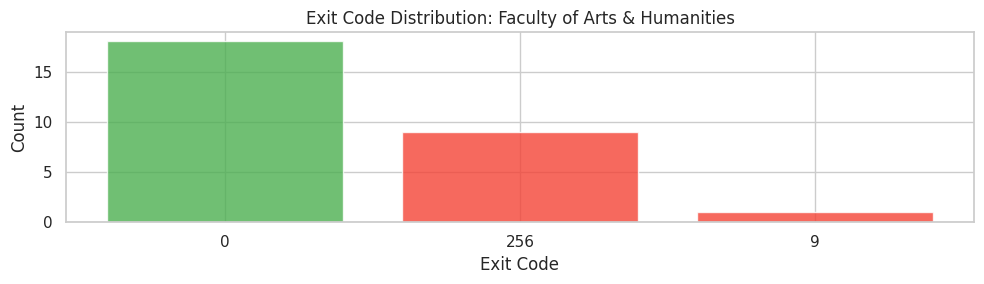

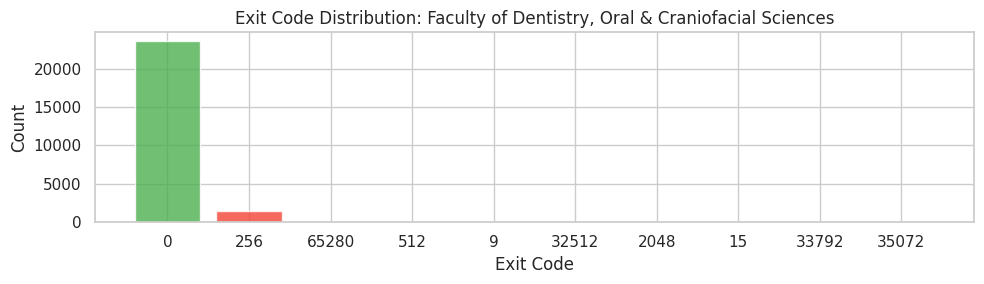

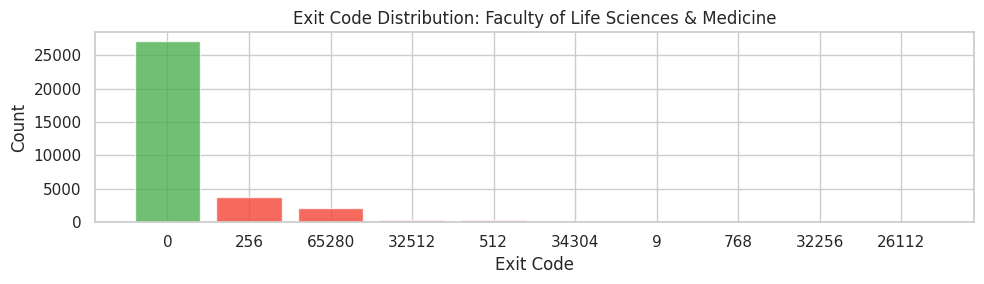

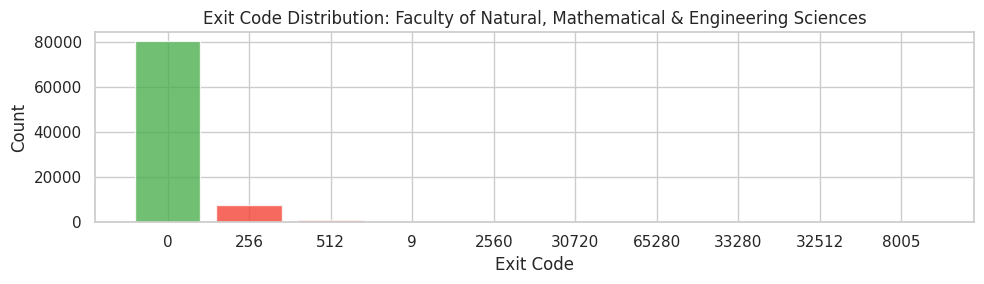

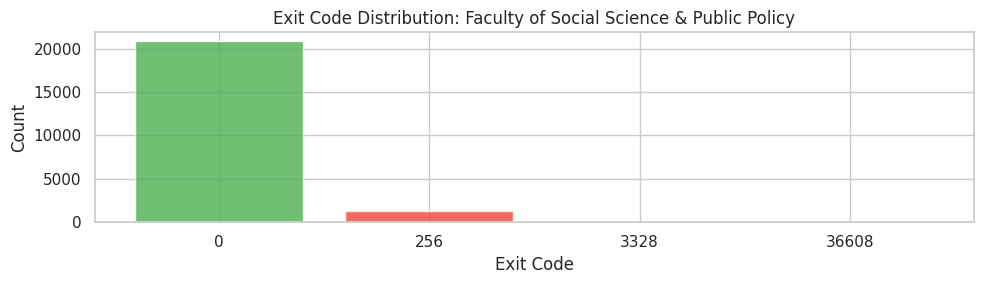

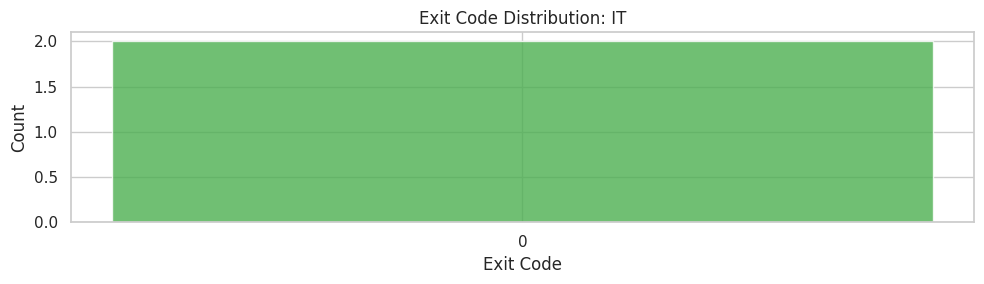

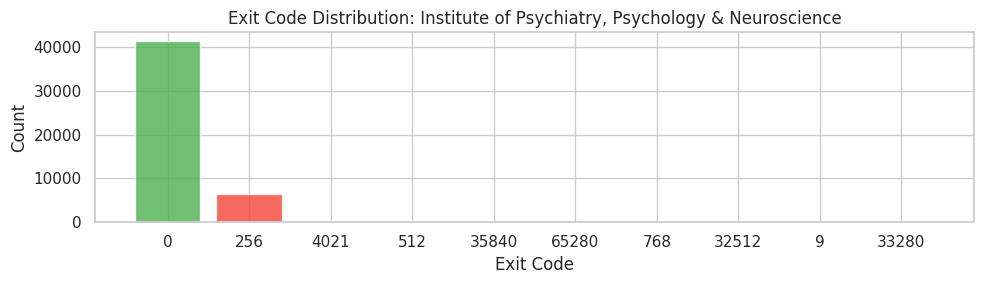

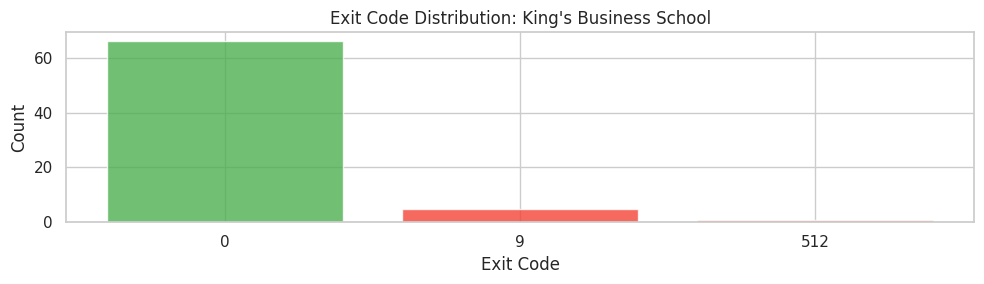

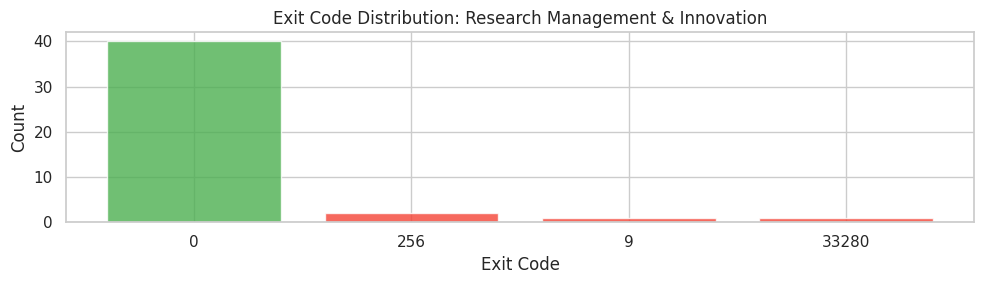

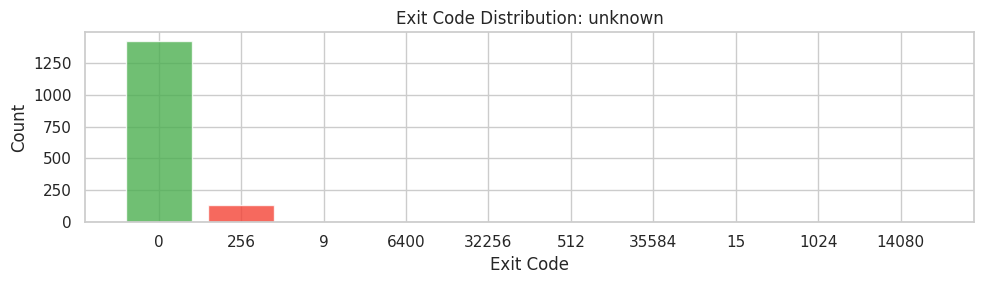

In [38]:
def parse_exit_codes(exit_code_str):
    if pd.isna(exit_code_str) or exit_code_str == '':
        return {}
    result = {}
    for pair in str(exit_code_str).strip('"').split(';'):
        if ':' in pair:
            code, count = pair.split(':')
            result[int(code)] = int(count)
    return result

display(Markdown("### Exit Code Analysis by Faculty"))

for _, row in df_faculties.iterrows():
    exit_codes = parse_exit_codes(row['exit_codes'])
    if not exit_codes:
        continue

    sorted_codes = sorted(exit_codes.items(), key=lambda x: -x[1])
    codes, counts = zip(*sorted_codes[:10])

    fig, ax = plt.subplots(figsize=(10, 3))
    colors = ['#4caf50' if c == 0 else '#f44336' for c in codes]
    ax.bar([str(c) for c in codes], counts, color=colors, alpha=0.8)
    ax.set_xlabel('Exit Code')
    ax.set_ylabel('Count')
    ax.set_title(f'Exit Code Distribution: {row["faculty"]}')
    plt.tight_layout()
    plt.show()